In [2]:
import gaps_online as go
import gaps_online.db as db
import re
from glob import glob
import numpy as np
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

In [3]:
calib = go.tof.calibrations.load_calibrations(Path('/data1/nextcloud/cra_data/data/2023_nevis/tof/calibration/20240305/'))

if len(calib.keys()) != 40: 
    missing = 40 -len(calib.keys())
    print(f'Oh no! {missing} calibrations are missing :(')
else: print('Yay! All calibration files were loaded :)')

Loading calibration files:  24%|▏| 10/41 [00:04<00:11,  2.78it/s]

Failed to get RB ID from file /data1/nextcloud/cra_data/data/2023_nevis/tof/calibration/20240305/Run122_1.2024_03_05-21_24_51.tof.gaps


Loading calibration files: 100%|█| 41/41 [00:17<00:00,  2.35it/s]

Yay! All calibration files were loaded :)


In [7]:
print(sorted(calib.keys()))
print(len(calib.keys()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 44, 46]
40


In [173]:
pattern = re.compile(r'/calibration/2024_03_21/RB(\d+)_\d{4}_\d{2}_\d{2}-\d{2}_\d{2}_\d{2}\.cali\.tof\.gaps')
calibrations = glob('/data1/nextcloud/cra_data/data/2023_nevis/tof/calibration/2024_03_21//*.cali.tof.gaps')
calib = {}


# Iterate over each file path
for fname in calibrations:
    #print("Processing file:", fname)
    # Search for the pattern in the file path
    match = pattern.search(fname)
    if match:
        print("Match found:", match.group())
        # Extract RB ID from the match
        rbid = match.group(1)
        calib[rbid] = go.cxx_api.RBCalibration.from_file(fname)
    else:
        print("No match found for:", fname)

Match found: /calibration/2024_03_21/RB15_2024_03_21-07_50_42.cali.tof.gaps
Match found: /calibration/2024_03_21/RB22_2024_03_21-07_50_37.cali.tof.gaps
Match found: /calibration/2024_03_21/RB28_2024_03_21-07_50_29.cali.tof.gaps
Match found: /calibration/2024_03_21/RB40_2024_03_21-07_50_32.cali.tof.gaps
Match found: /calibration/2024_03_21/RB42_2024_03_21-07_50_37.cali.tof.gaps
Match found: /calibration/2024_03_21/RB14_2024_03_21-07_50_43.cali.tof.gaps
Match found: /calibration/2024_03_21/RB13_2024_03_21-07_50_43.cali.tof.gaps
Match found: /calibration/2024_03_21/RB20_2024_03_21-07_50_41.cali.tof.gaps
Match found: /calibration/2024_03_21/RB03_2024_03_21-07_50_43.cali.tof.gaps
Match found: /calibration/2024_03_21/RB02_2024_03_21-07_50_29.cali.tof.gaps
Match found: /calibration/2024_03_21/RB09_2024_03_21-07_50_37.cali.tof.gaps
Match found: /calibration/2024_03_21/RB07_2024_03_21-07_50_29.cali.tof.gaps
Match found: /calibration/2024_03_21/RB16_2024_03_21-07_50_37.cali.tof.gaps
Match found:

In [4]:
fixed_path = "/data1/nextcloud/cra_data/data/2023_nevis/tof/138/Run138"

files = glob(f'{fixed_path}_*.tof.gaps')
print(len(files[0]))
print(files[0])

87
/data1/nextcloud/cra_data/data/2023_nevis/tof/138/Run138_1.2024_03_28-19_26_42.tof.gaps


In [5]:
test_file = "/data1/nextcloud/cra_data/data/2023_nevis/tof/138/Run138_1.2024_03_28-22_58_50.tof.gaps"

In [6]:
data = go.tof.get_tofpackets(test_file, filter=go.cxx_api.PacketType.TofEvent)
evts = [go.cxx_api.TofEvent.from_tofpacket(k) for k in data]

print(len(data))
print(len(evts))

49008
49008


In [7]:
ch9 = {}
ch9_hits = defaultdict(list)

betas = []
phases = {} 

for ev in tqdm(evts[:100]):
    rbids = ev.get_rbids()
    if 15 not in rbids or 16 not in rbids: continue 
    
    #rbevents = [ev.get_rbevent(k) for k in rbids]
    for event_id in (ev.get_rbevent(k) for k in rbids):
        if event_id.header.rb_id == 0: continue 
        key = event_id.header.rb_id
        if len(str(key)) > 2: continue #error where some ids are in the hundreds
        try:
            calibration = calib[key]
            
        except Exception as e:
        #     #print(e)
            continue
        voltage_calib = calibration.voltages(event_id)
        time_calib = calibration.nanoseconds(event_id)

        tt = np.linspace(0, 500, 1024)
        ch9_voltages = voltage_calib[8]

        res = fit_sine(tt, ch9_voltages)
        
        phase = float(res['phase'])
        omega = float(res['omega'])

        phase_shift = phase/omega
        phases[rb_id] = phase_shift
        
        if phase_shift < 0: 
            phase_shift = -phase_shift
        
        
        for h in event_id.hits:
    
            if h.paddle_id != 6 and h.paddle_id != 66: continue #example using specific paddles, this can be removed
            
            x_position = h.x_pos
            t_avg = h.t_avg
            if event_id not in ch9_hits:
                ch9_hits[event_id] = {}
                
            ch9_hits[event_id][h.paddle_id] = {'x_position': x_position, 't_avg': t_avg, 'phase_shift' : phase_shift}
            print(h.paddle_id)

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'fit_sine' is not defined

In [247]:
for event_id, paddle_data in ch9_hits.items():
    for paddle_id in paddle_data.keys():
        print("Paddle ID:", paddle_id)
        print(type(paddle_id))

Paddle ID: 6
<class 'int'>
Paddle ID: 66
<class 'int'>
Paddle ID: 6
<class 'int'>
Paddle ID: 6
<class 'int'>
Paddle ID: 66
<class 'int'>
Paddle ID: 66
<class 'int'>
Paddle ID: 6
<class 'int'>
Paddle ID: 6
<class 'int'>


In [243]:
for event_id, paddle_data in ch9_hits.items():
    for paddle_id, data in paddle_data.items():
        
        
        # x_pos = ch9_hits[event_id][paddle_id]['x_position'] #units of mm
        # times = ch9_hits[event_id][paddle_id]['t_avg'] #units of nsec

        # print(x_pos)
        # print(times)

        paddle_66_loc =1989 
        paddle_66_cblen = 2950
        paddle_6_loc = 1287
        paddle_6_cblen = 3750

        delta_loc = paddle_66_loc - paddle_6_loc
        ratio_cblen = paddle_66_cblen / paddle_6_cblen
        
        # time_paddle_6 = ch9_hits[event_id][6]['t_avg']
        # time_paddle_66 = ch9_hits[66][1][1]
        # x_pos_6 = ch9_hits[6][1][0]
        # x_pos_66 = ch9_hits[66][1][0]

        time_paddle_6 = ch9_hits[event_id][6]['t_avg']
        time_paddle_66 = ch9_hits[event_id][66]['t_avg']
        print('event id:' + str(event_id))
        print('time_paddle_6:' + str(time_paddle_6))
        print('time_paddle_66:' + str(time_paddle_66))
        
        x_pos_6 = ch9_hits[event_id][6]['x_position']
        x_pos_66 = ch9_hits[event_id][66]['x_position']
        
        phase_shift_6 = ch9_hits[event_id][6]['phase_shift']
        phase_shift_66 = ch9_hits[event_id][66]['phase_shift']

        time_paddle_6 = time_paddle_6 * ratio_cblen

        time_paddle_6 -= phase_shift_6

        time_paddle_66 -= phase_shift_66

        absolute_time = abs(time_paddle_6 - time_paddle_66) #mm
        absolute_x_diff = abs(x_pos_6 - x_pos_66) #nanosecond

        absolute_time = absolute_time / 1000 #m
        absolute_x_diff = absolute_x_diff / (10**9)#sec

        beta = absolute_x_diff / absolute_time 
        beta = beta/(3*10**8)
        betas.append(beta)
print(betas)

KeyError: 66

In [222]:


for event_id, paddle_data in ch9_hits.items():
    for paddle_id, data in paddle_data.items():
        
        
        # x_pos = ch9_hits[event_id][paddle_id]['x_position'] #units of mm
        # times = ch9_hits[event_id][paddle_id]['t_avg'] #units of nsec

        # print(x_pos)
        # print(times)

        paddle_66_loc =1989 
        paddle_66_cblen = 2950
        paddle_6_loc = 1287
        paddle_6_cblen = 3750

        delta_loc = paddle_66_loc - paddle_6_loc
        ratio_cblen = paddle_66_cblen / paddle_6_cblen
        
        # time_paddle_6 = ch9_hits[event_id][6]['t_avg']
        # time_paddle_66 = ch9_hits[66][1][1]
        # x_pos_6 = ch9_hits[6][1][0]
        # x_pos_66 = ch9_hits[66][1][0]

        time_paddle_6 = ch9_hits[event_id][6]['t_avg']
        time_paddle_66 = ch9_hits[event_id][66]['t_avg']

        x_pos_6 = ch9_hits[event_id][6]['x_position']
        x_pos_66 = ch9_hits[event_id][66]['x_position']
        
        phase_shift_6 = ch9_hits[event_id][6]['phase_shift']
        phase_shift_66 = ch9_hits[event_id][66]['phase_shift']

        time_paddle_6 = time_paddle_6 * ratio_cblen

        time_paddle_6 -= phase_shift_6

        time_paddle_66 -= phase_shift_66

        absolute_time = abs(time_paddle_6 - time_paddle_66)
        absolute_x_diff = abs(x_pos_6 - x_pos_66)

        beta = absolute_x_diff / absolute_time 
        beta = beta/(3*10**8)
        betas.append(beta)
print(betas)
            #ch9_hits[filler.event_id].append((x_position, t_avg))
    #phases = {} 
    #for event_id in rbevents:
    #     if event_id.header.rb_id == 0: continue 
    
    #     str_id = f'{event_id.header.rb_id:02d}'
        # key = event_id.header.rb_id
        # if len(str_id) > 2: continue #error where some ids are in the hundreds
        
        # try:
        #     calibration = calib[key]
            
        # except Exception as e:
        #     #print(e)
        #     continue
        # voltage_calib = calibration.voltages(event_id)
        # time_calib = calibration.nanoseconds(event_id)

        # tt = np.linspace(0, 500, 1024)
        # ch9_voltages = voltage_calib[8]

        # res = fit_sine(tt, ch9_voltages)
        
#         phase = float(res['phase'])
#         omega = float(res['omega'])

#         phase_shift = phase/omega
#         phases[rb_id] = phase_shift
        
#         if phase_shift < 0: 
#             phase_shift = -phase_shift
        
        
#         paddle_66_loc =1989 
#         paddle_66_cblen = 2950
#         paddle_6_loc = 1287
#         paddle_6_cblen = 3750

#         delta_loc = paddle_66_loc - paddle_6_loc

#         time_paddle_6 = ch9_hits[event_id][6]['t_avg']
#         time_paddle_66 = ch9_hits[66][1][1]
#         x_pos_6 = ch9_hits[6][1][0]
#         x_pos_66 = ch9_hits[66][1][0]
        
#         ratio_cblen = paddle_66_cblen / paddle_6_cblen

#         time_paddle_6 = time_paddle_6 * ratio_cblen

#         time_paddle_6 -= phases[6]

#         time_paddle_66 -= phases[66]

#         absolute_time = abs(time_paddle_6 - time_paddle_66)
#         absolute_x_diff = abs(x_pos_6 - x_pos_66)

#         beta = absolute_x_diff / absolute_time 
#         beta = beta/(3*10**8)
#         betas.append(beta)
#         # ch9_times = time_calib[8]
#         # identifier = event_id.header.event_id
#         #pregunta = event_id.header.get_sine_fit
#         #print(pregunta)
#         if event_id not in ch9:
#         #     ch9[identifier] = {}
#         # ch9[identifier][str_id] = {'voltages': ch9_voltages, 'times': ch9_times}
# print(betas)

  0%|          | 0/30 [00:00<?, ?it/s]

KeyError: 66

In [218]:
print(ch9_hits.keys())

dict_keys([<RBEvent
  status    : <EventStatus: Unknown>
<RBEventHeader
  rb id          16
  event id       5225977
  is locked      1
  is locked (1s) 1
  lost trigger   0
  event fragment 0
  channel mask   268
  |-> channels    2  3  8 
  stop cell      427
  ** online ch9 fit amp, freq, phase
    AMP 3.823148  FREQ 0.900130  PHASE 4.609598
  timestamp32    3061130693
  timestamp16    88
  |->timestamp48 381018252741
  FPGA temp [C]  53.769329>
 -- -- adc -- --
 2: ..3624 4580 .. ..
 3: ..4229 4568 .. ..
 8: ..5343 5082 .. ..

 ** ** hits ** **
<TofHit
  paddle ID         : 4
  timestamp32       : 0
  timestamp16       : 0
   |-> timestamp48  : 0.000000
  _________
  ##  Peak:
  >> time   A | B  : 56.068 49.780003
  >>  height A | B  : 1918.4 5232
  >>  charge A | B  : -10.700001 15.5
  >>  charge min_I  : 29.300003
  >>  in pad. pos   : 163.874985
  >>  t_avg         : 49.780003
  cntr ETX          : 0
  broken (?depr)    : 0>
>])


In [8]:
import scipy.optimize
from scipy.stats import chi2


def fit_sine(nanoseconds, volts):
    tt = np.array(nanoseconds)
    yy = np.array(volts)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt

    phase_multiple_pi = p / np.pi

    # Calculate R-squared
    residuals = yy - sinfunc(tt, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((yy - np.mean(yy))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Calculate expected values from the fitted sine curve
    expected_values = sinfunc(tt, *popt)
    
    # Calculate observed frequencies
    observed_values, _ = np.histogram(yy, bins=len(tt))
    
    # Calculate chi-squared statistic
    chi_squared_stat = np.sum((observed_values - expected_values)**2 / expected_values)
    
    # Determine degrees of freedom
    df = len(tt) - len(popt)

    reduced_chi_squared = chi_squared_stat / df
    
    # Calculate p-value using chi-square distribution
    p_value = 1 - chi2.cdf(chi_squared_stat, df)
    
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": f"{A:.2f}", "omega": f"{w:.2f}", "phase" : f"{p: .2f}", "phase_formatted": f"{phase_multiple_pi:.2f}π", "offset": f"{c:.2f}", "freq": f"{f:.2f}", "period": f"{1./f:.2f}", "fitfunc": fitfunc, "maxcov": f"{np.max(pcov):.2f}", "rawres": (guess,popt,pcov), "r_squared": f"{r_squared:.2f}", "chi_squared_stat": f"{chi_squared_stat:.2f}",
            "p_value": f"{p_value:.2f}", 'reduced_chi_squared': f"{reduced_chi_squared:.2f}"}



    


In [9]:
for event_id, rb_data in ch9.items():
    for rb_id, data in rb_data.items():
        
        tt = np.linspace(0, 500, 1024)
        voltages = ch9[event_id][rb_id]['voltages']
        times = ch9[event_id][rb_id]['times']

        res = fit_sine(tt, voltages)
        phase_from_fit = float(res['phase'])
        omega = float(['omega'])

        phase_shift = phase/omega
        
        if phase_shift >= 0: 
            voltage_shifted = np.roll(voltages, phase_shift)
            
        else: 
            voltage_shifted = np.roll(voltages, -phase_shift)
    

        res2 = fit_sine(tt, voltage_shifted)
        print( "Amplitude=%(amp)s, \nAngular freq.=%(omega)s, \nphase=%(phase)s, \noffset=%(offset)s" % res2 )

        plt.plot(tt, voltage_shifted, label = 'shifted voltage')
        plt.plot(tt, res2["fitfunc"](data['times']), "r-", label="ch. 9 fit", linewidth=2)
        plt.xlabel('Time (ns)')
        plt.ylabel('Voltages')
        plt.legend(loc="best")
        plt.show()

In [ ]:
#paddle 6 and 66, middle of umbrella, middle of tof cube
#should be directly on top of eachother

# paddle_66_loc =1989 
# paddle_66_cblen = 2950
# paddle_6_loc = 1287
# paddle_6_cblen = 3750



In [10]:


for event_id, rb_data in ch9.items():
    plt.figure()
    plt.title(f"Event ID {event_id}")
    
    for rb_id, data in rb_data.items():
        tt = np.linspace(0, 500, 1024)
        res = fit_sine(tt, data['voltages'])
        print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s, R^2=%(r_squared)s, Chi^2=%(chi_squared_stat)s, p-value=%(p_value)s, reduced_chi_squared=%(reduced_chi_squared)s" % res )

        # phase_fit = res['phase']
        # phase_diff = phase_fit - 0 #goal: align all waves w phase 0
        # #shift_amount = int(phase_diff / (2 * np.pi) * 1024)

        # if phase_diff > 0: #if phase difference is +, the phase difference must be subtracted
        #     shift_amount = int((phase_diff/(2*np.pi))*1024)
        #     voltage_shifted = np.roll(data['voltages'], -shift_amount)
        # else: 
        #     shift_amount = int((abs(phase_diff)/ (2 * np.pi))*1024)
        #     voltage_shifted = np.roll(data['voltages'], shift_amount)
            

        offset = res['offset']
        amp = res['amp']
        freq = res['omega']
        phase = res['phase']
        
        if float(offset) >0:
            data['voltages'] -= float(offset)
        else: data['voltages'] += float(offset)

        phase_diff = phase

        if float(phase_diff) > 0:
            shifted_wv = amp * np.sin(float(freq)*tt + (float(phase) - float(abs(phase_diff)))) + (v_shift)
        else: 
            shifted_wv = amp * np.sin(float(freq)*tt + (float(phase) - float(phase_diff))) + float(v_shift)

        res2 = fit_sine(tt, shifted_wv)
        print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s" % res2 )

        #plt.plot(data['times'], data['voltages'], "-k", label=f'RB {rb_id}', linewidth=2)
        plt.plot(tt, shifted_wv, label = 'shifted voltage')
        #plt.plot(tt, res2["fitfunc"](data['times']), "r-", label="ch. 9 fit", linewidth=2)
        plt.xlabel('Time (ns)')
        plt.ylabel('Voltages')
        plt.legend(loc="best")
        plt.show()

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

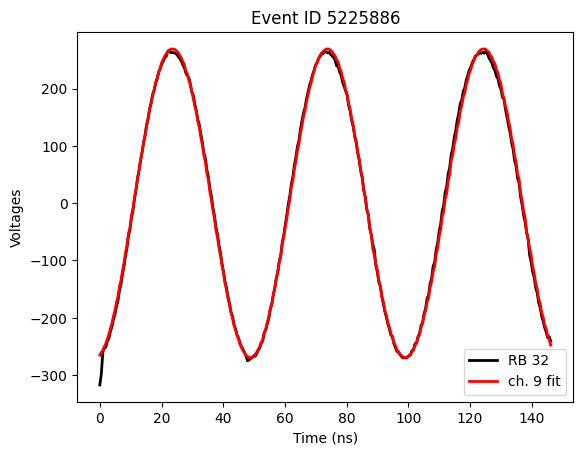

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

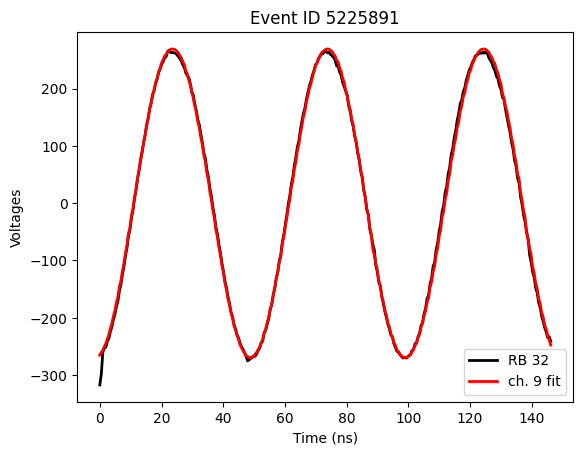

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

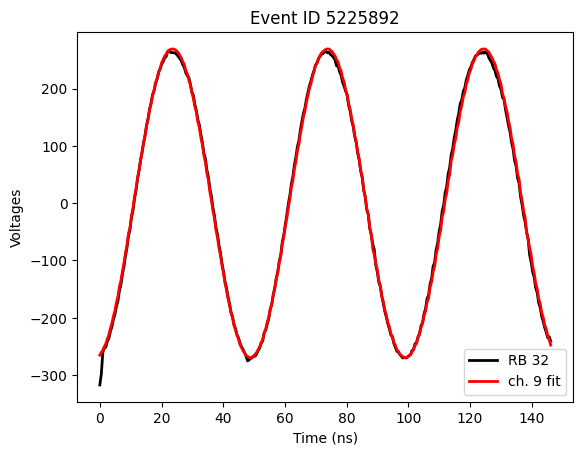

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

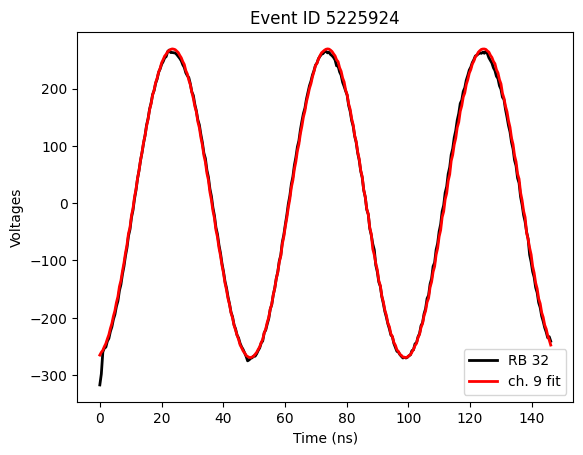

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

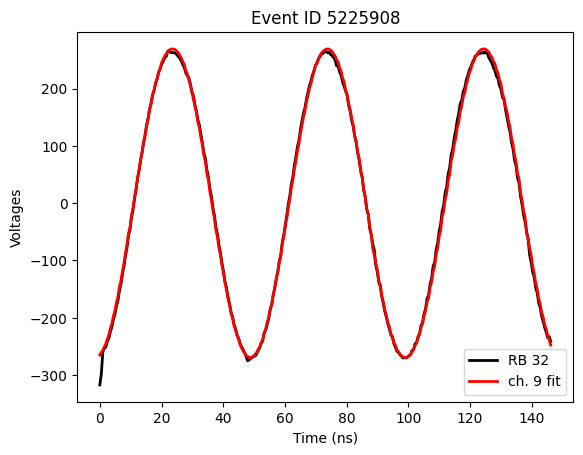

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

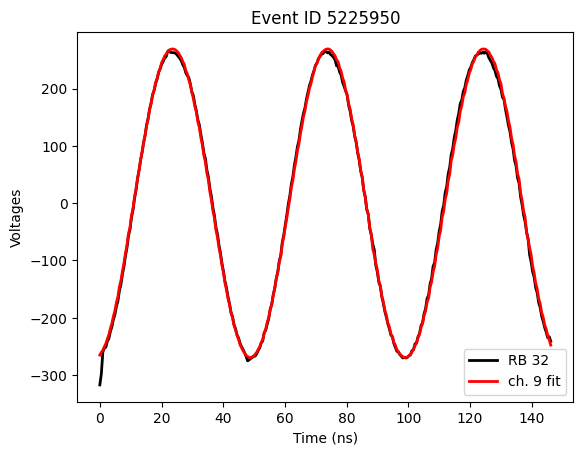

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

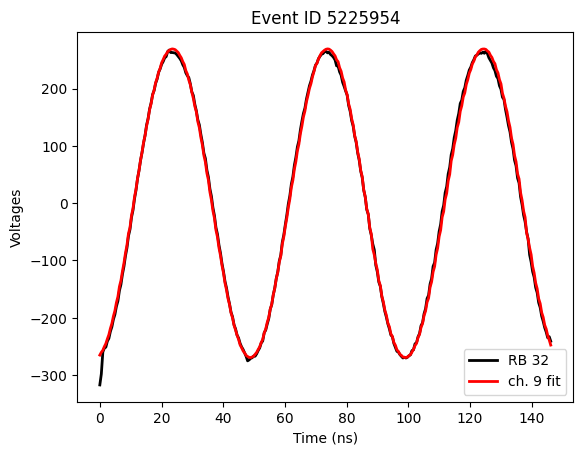

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

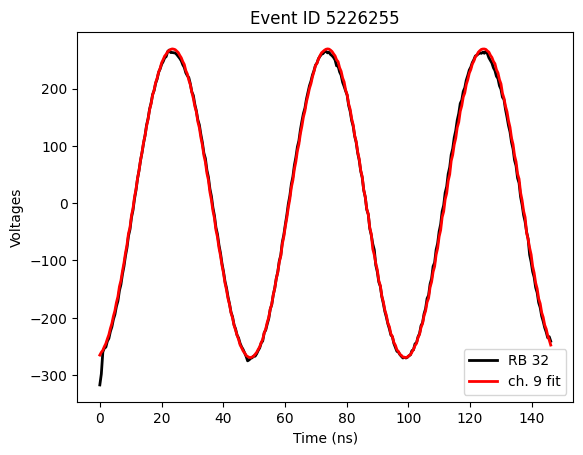

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

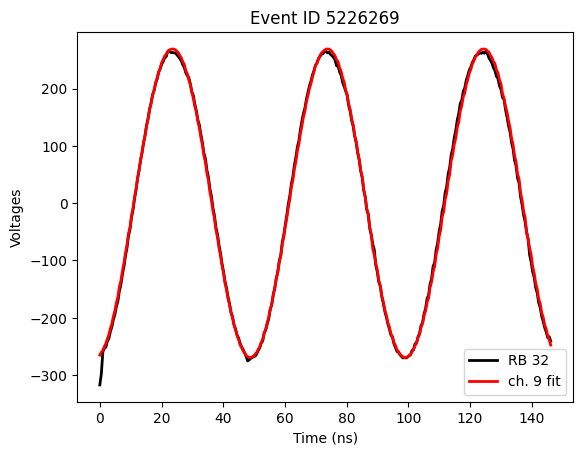

[-317.08688   -297.97794   -259.56088   -252.97664   -251.15193
 -240.7982    -235.94151   -223.90451   -215.75777   -202.87325
 -194.22641   -180.18254   -170.68602   -152.64844   -141.90129
 -124.07368   -110.46992    -92.10232    -77.98266    -57.18578
  -45.833347   -24.798786   -12.216217     7.707306    22.803877
   42.67565     57.175533    74.54884     88.49061    104.692184
  118.327705   136.22826    147.57677    164.17044    174.76941
  189.58455    196.46458    209.00209    216.47136    228.3302
  234.21886    242.33885    247.035      253.47263    255.64731
  264.51587    267.08792    262.7579     262.81998    262.304
  261.9319     259.31384    256.01395    252.54102    248.35728
  241.586      236.84991    227.52196    222.51971    219.07416
  208.36562    194.23767    187.94756    172.40596    161.16501
  145.40216    136.57715    119.98235    105.97387     87.40879
   78.146866    57.751556    45.612503    25.096432    12.157065
   -7.8431387  -21.599346   -42.39807   

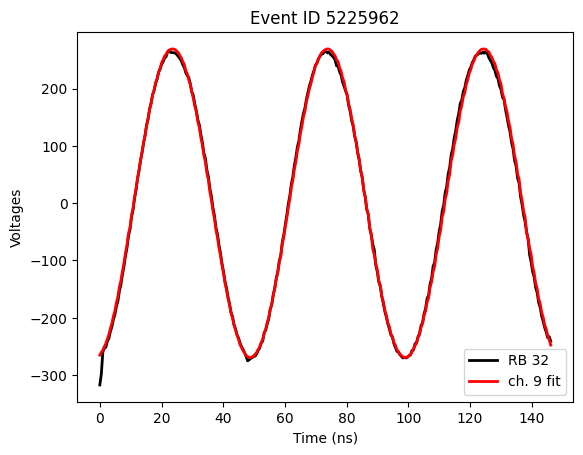

In [157]:
#first periods only

for event_id, rb_data in ch9.items():
    plt.figure()
    plt.title(f"Event ID {event_id}")
    n_bins = 300

    tt = np.linspace(0, 500, 1024)
    time = data['times']
    volt = data['voltages']
    #print(len(tt), len(time), len(volt))
    
    #tt_cut = tt[10:]
    tt_cut = tt[:n_bins]
    
    #time_cut = time[10:]
    time_cut = time[:n_bins]

    #print(len(tt_cut), len(time_cut))
    
    #volt_cut = volt[10:]
    volt_cut = volt[:n_bins]
    print(volt_cut)
    #print(len(volt), len(volt_cut))
    #tt_small = tt[:n_bins]

    
    res = fit_sine(tt_cut, volt_cut)
    print( "Amplitude=%(amp)s, \nAngular freq.=%(omega)s, \nphase=%(phase)s, \noffset=%(offset)s, \nMax. Cov.=%(maxcov)s, \nR^2=%(r_squared)s, \nChi^2=%(chi_squared_stat)s, \np-value=%(p_value)s, \nreduced_chi_squared=%(reduced_chi_squared)s" % res )

    plt.plot(tt_cut, volt_cut, "-k", label=f'RB {rb_id}', linewidth=2)
    plt.plot(tt_cut, res["fitfunc"](time_cut), "r-", label="ch. 9 fit", linewidth=2)
    plt.xlabel('Time (ns)')
    plt.ylabel('Voltages')
    plt.legend(loc="best")
    plt.show()

In [ ]:
file = "/data1/nextcloud/cra_data/data/2023_nevis/tof/121/Run121_1.2024_03_05-09_47_33.tof.gaps"
file1 = "/data1/nextcloud/cra_data/data/2023_nevis/tof/138/Run138_10.2024_03_28-21_04_14.tof.gaps"

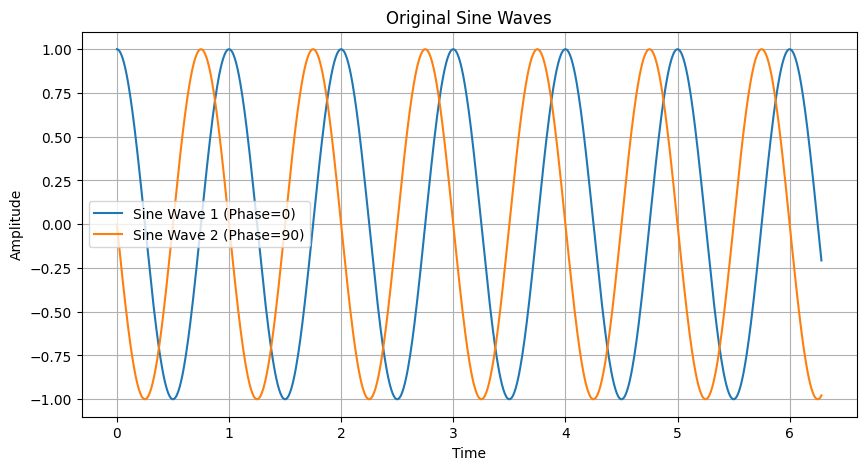

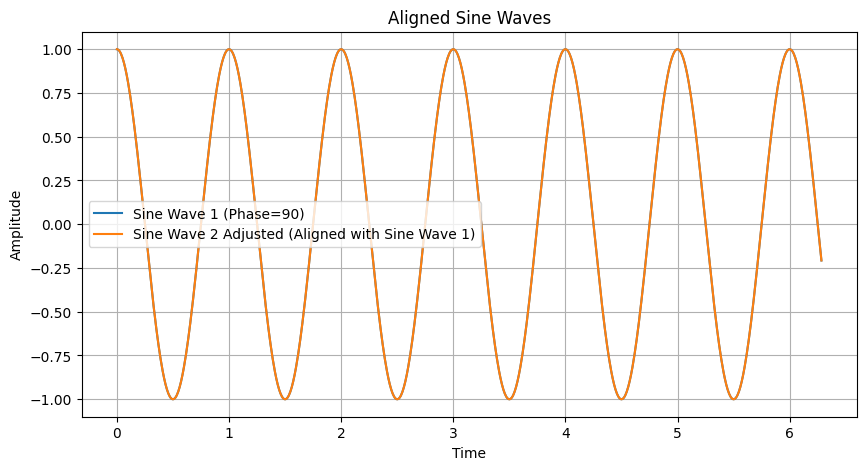

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
frequency = 1  # Frequency of the sine waves (in Hz)
amplitude = 1  # Amplitude of the sine waves
phase1 = 90     # Phase of the first sine wave (in degrees)
phase2 = 180    # Phase of the second sine wave (in degrees)

# Time array
t = np.linspace(0, 2*np.pi, 1000)  # 1000 points from 0 to 2*pi

# Sine wave equations
y1 = amplitude * np.sin(2*np.pi*frequency*t + np.deg2rad(phase1))
y2 = amplitude * np.sin(2*np.pi*frequency*t + np.deg2rad(phase2))

# Plot original sine waves
plt.figure(figsize=(10, 5))
plt.plot(t, y1, label='Sine Wave 1 (Phase=0)')
plt.plot(t, y2, label='Sine Wave 2 (Phase=90)')
plt.title('Original Sine Waves')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Calculate phase difference
phase_difference = phase2 - phase1

# Adjust phase of the second sine wave to align with the first one
y2_adjusted = amplitude * np.sin(2*np.pi*frequency*t + np.deg2rad(phase2 - phase_difference))

# Plot aligned sine waves
plt.figure(figsize=(10, 5))
plt.plot(t, y1, label='Sine Wave 1 (Phase=90)')
plt.plot(t, y2_adjusted, label='Sine Wave 2 Adjusted (Aligned with Sine Wave 1)')
plt.title('Aligned Sine Waves')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

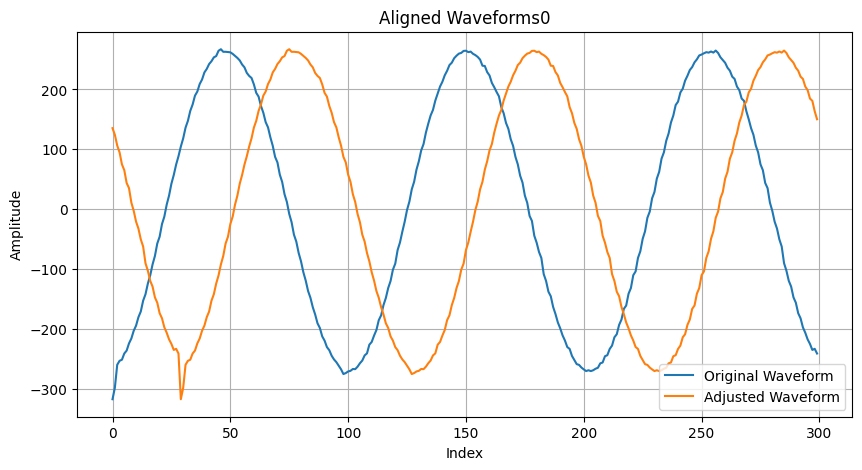

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



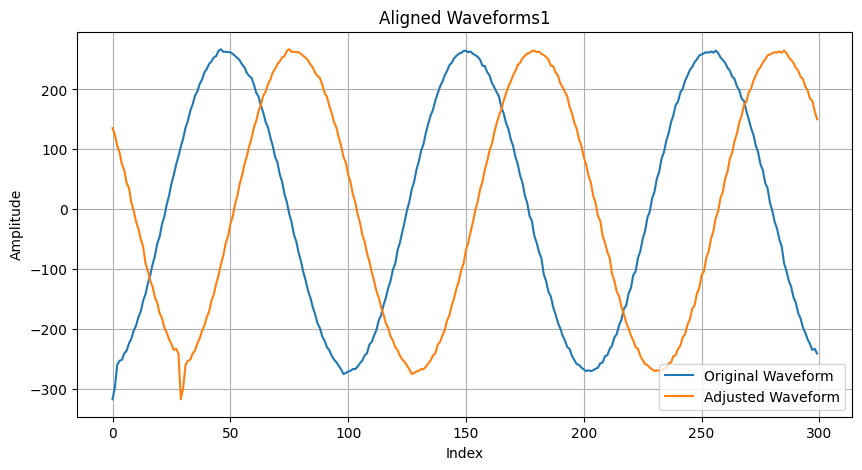

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



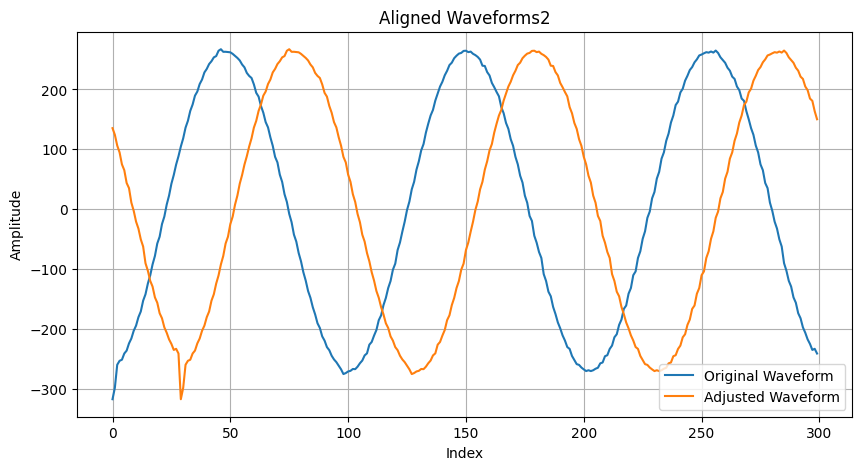

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



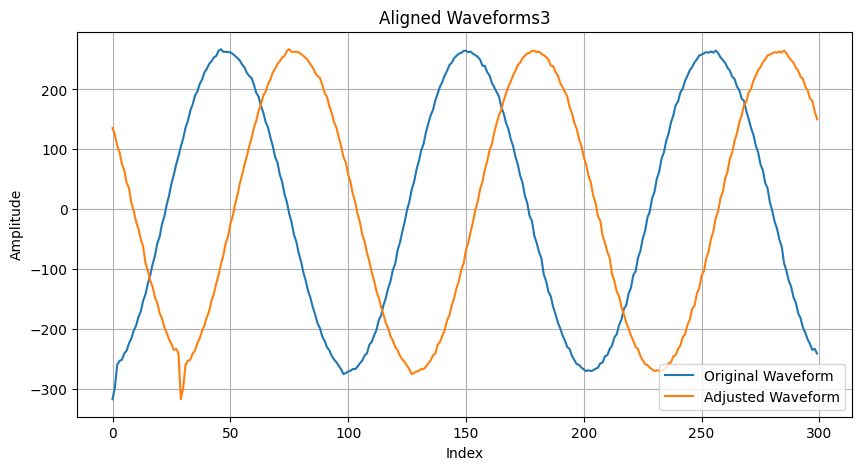

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



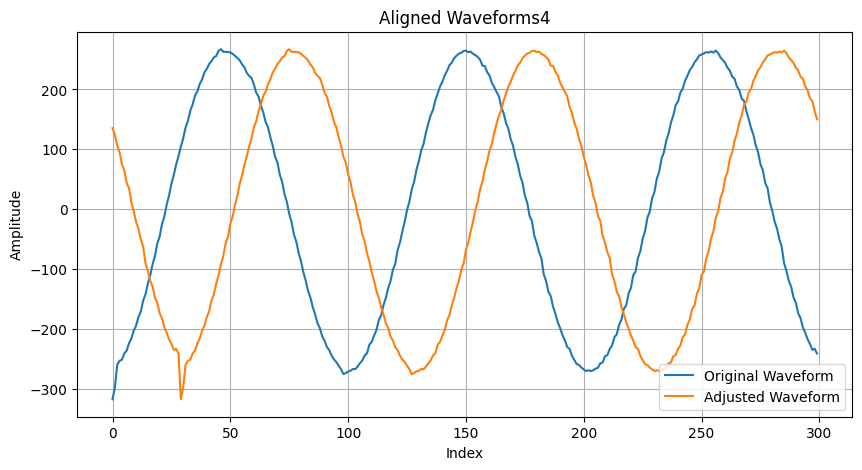

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



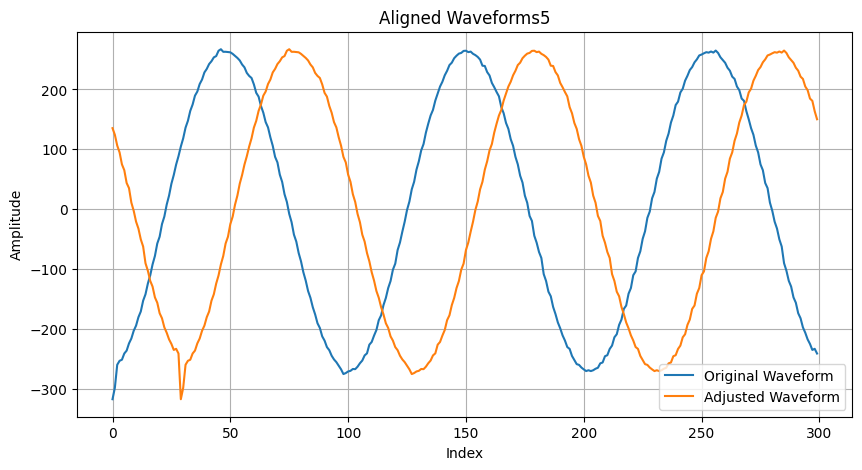

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



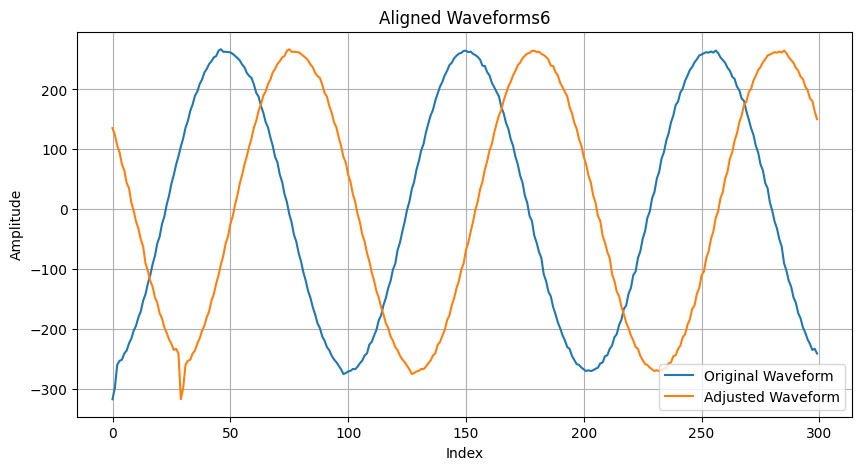

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



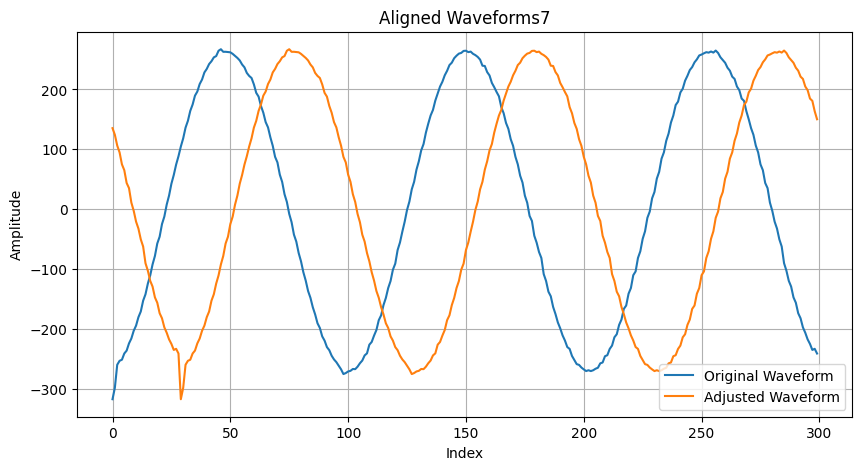

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



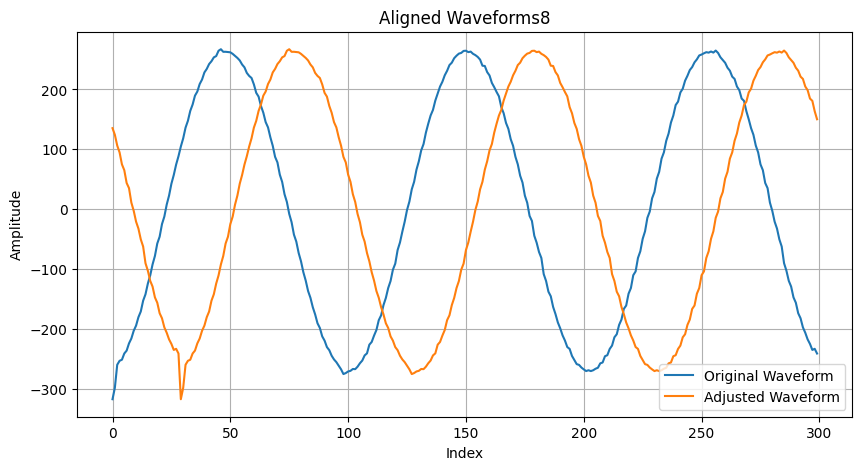

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



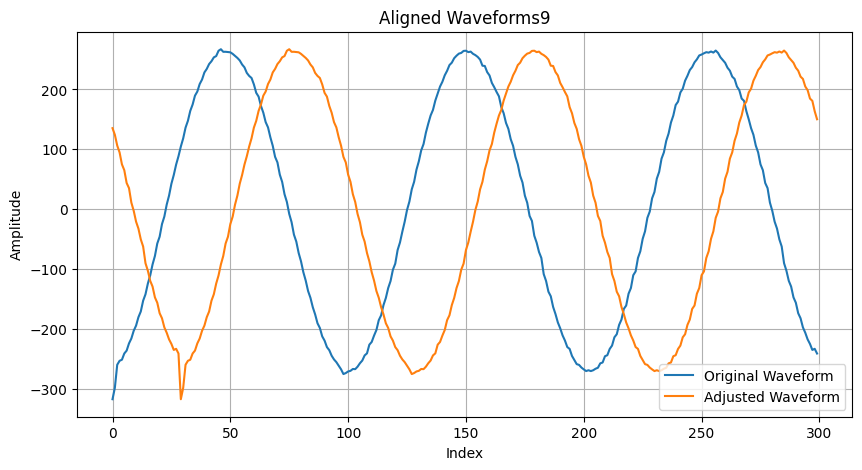

Original: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

After fitting: 
Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80

10


In [164]:
from scipy.signal import find_peaks

counter = 0
for event_id, rb_data in ch9.items():
    n_bins = 300

    tt = np.linspace(0, 500, 1024)
    time = data['times']
    volt = data['voltages']
    #print(len(tt), len(time), len(volt))
    
    #tt_cut = tt[10:]
    tt_cut = tt[:n_bins]
    
   

    volt_cut = volt[:n_bins]
    #print(volt_cut)
    waveform_data = volt_cut  # Your data goes here

    # Find peaks in the waveform data
    peaks, _ = find_peaks(waveform_data)
    
    # Calculate the phase based on the position of peaks
    phase = (peaks[0] / len(waveform_data)) * 360  # Assuming the first peak is at the start of a cycle
    
    # Define the phase of the second waveform (you need to determine this from your data)
    target_phase = 90  # Example phase for demonstration
    
    # Calculate phase difference
    phase_difference = target_phase - phase
    
    # Adjust phase of the waveform data
    adjusted_waveform_data = np.roll(waveform_data, int(phase_difference / 360 * len(waveform_data)))
    
    
    # Plot original and adjusted waveforms
    plt.figure(figsize=(10, 5))
    plt.plot(waveform_data, label='Original Waveform')
    plt.plot(adjusted_waveform_data, label='Adjusted Waveform')
    plt.title('Aligned Waveforms' + str(counter))
    plt.xlabel('Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    res5 = fit_sine(tt_cut, volt_cut)
    print( "Original: \nAmplitude=%(amp)s, \nAngular freq.=%(omega)s, \nphase=%(phase)s, \noffset=%(offset)s\n" % res3 )
    res4 = fit_sine(tt_cut, adjusted_waveform_data)
    print( "After fitting: \nAmplitude=%(amp)s, \nAngular freq.=%(omega)s, \nphase=%(phase)s, \noffset=%(offset)s\n" % res3 )
    counter += 1

print(counter)

In [135]:
phase_list = []
aligned_waveforms = []
for event_id, rb_data in ch9.items():
    
    for rb_id, data in rb_data.items():
        tt = np.linspace(0, 500, 1024)
        res = fit_sine(tt, data['voltages'])
        #print( "Amplitude=%(amp)s, \nAngular freq.=%(omega)s, \nphase=%(phase)s, \noffset=%(offset)s\n" % res )
            

        offset = res['offset']
        amp = res['amp']
        freq = res['omega']
        phase = res['phase']

        phase_list.append(phase)

max_phase = max(phase_list)
med_phase = np.median(phase_list)

for voltages, times, phase in zip(data['voltages'].astype(float), tt, phase_list):
        # Calculate the phase shift needed to align the waveform's phase to 0
        phase_shift = med_phase - phase
        
        # Apply the phase shift to the waveform
        shifted_voltages = np.roll(data['voltages'], -int(phase_shift))
        
        # Append the aligned waveform to the list
        aligned_waveforms.append(shifted_voltages)
    

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None

In [124]:
def align_waveforms(voltages_list, times_list):
    aligned_waveforms = []
    
    for voltages, times in zip(voltages_list, times_list):
        # Calculate phase for the current waveform
        phase = fit_sine(times_list, voltages_list)['phase']
        
        # Determine the phase shift required to align the waveform's phase to 0
        phase_shift = -float(phase)
        
        # Apply the phase shift to the waveform
        shifted_voltages = np.roll(voltages, int(phase_shift))
        
        # Append the aligned waveform to the list
        aligned_waveforms.append(shifted_voltages)
    
    return aligned_waveforms

Amplitude=277.05, 
Angular freq.=0.13, 
phase=0.67π, 
offset=2.80



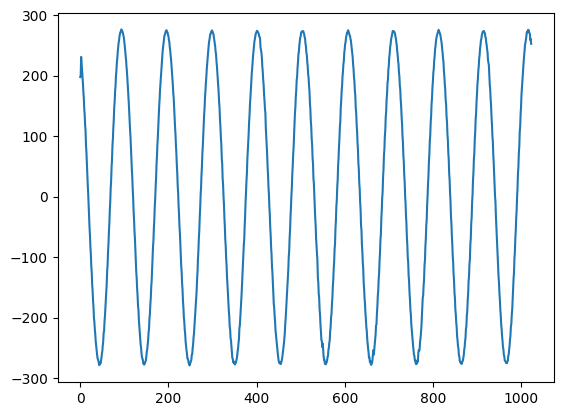

In [134]:
aligned_wvs = align_waveforms (data['voltages'], data['times'])

plt.plot(aligned_wvs)
res = fit_sine(tt, aligned_wvs)
print( "Amplitude=%(amp)s, \nAngular freq.=%(omega)s, \nphase=%(phase)s, \noffset=%(offset)s\n" % res3 )

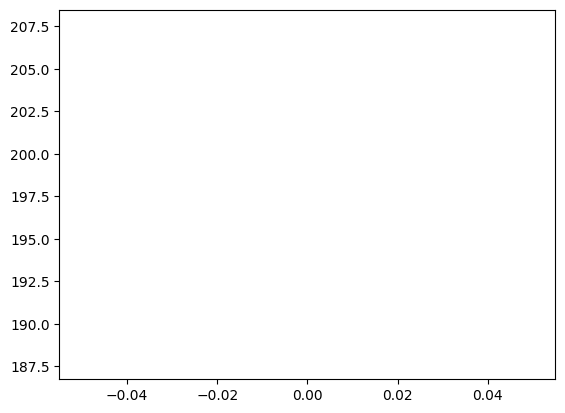

IndexError: tuple index out of range

In [126]:
for wv in aligned_wvs:
    
    plt.figure()
    plt.plot(wv)
    plt.show()
    
    res3 = fit_sine(tt, wv)
    print( "Amplitude=%(amp)s, \nAngular freq.=%(omega)s, \nphase=%(phase)s, \noffset=%(offset)s\n" % res3 )